In [5]:
import numpy as np
import jax.numpy as jnp
import jax

import matplotlib.pyplot as plt
from rikabplotlib.plot_utils import newplot


# Notes

We can parameterize a CDF from $x \in [0,a]$ by:

$P(X \leq x) = \exp(-\log(\frac{a}{x}))$

When $x$ approaches 0 from above, the CDF approaches 0. When $x$ approaches $a$ from below, the CDF approaches 1.
The corresponding PDF is:

$p(x) = \frac{1}{x} \exp(-\log(\frac{a}{x}))$.

-------------------------------------------------

Now let's generalize. We can parameterize *all* CDFS on $[0,1]$ (choose $a = 1$ for simplicity) by:

$P(X \leq x) = \exp[-f\left(\log(\frac{1}{x})\right)]$

where $f(t)$ (where $t = \log(1/x)$) is a strictly increasing function on $(0, \infty)$ with $f(0) = 0$ and $f(\infty) = \infty$.
When $x$ approaches 0 from above, the argument of $f$ approaches $\infty$, so the CDF approaches 0. When $x$ approaches 1 from below, the argument of $f$ approaches 0, so the CDF approaches 1.

The corresponding PDF is:

$p(x) = \frac{f'\left(\log(\frac{1}{x})\right)}{x} \exp[-f\left(\log(\frac{1}{x})\right)]$.


-------------------------------------------------

The function $f$ must be strictly increasing, so $f'(t) > 0$ for all $t > 0$, and $f(0) = 0$.
%
This implies that we can write:

$f(t) = \int_0^t ds f'(s) $.

So, we can simply choose $f'(t)$ and then integrate to get $f(t)$. We just have to make sure that $f'(t)$ is strictly positive.

-------------------------------------------------

I can think of a few options for us:

1. Do integrable networks exist? Then we can just parameterize $f'(t)$ and integrate to get $f(t)$. It should be easy to ensure f'(t) is positive using activation functions. Or, maybe we can compromise and do some kind of approximation to the integral. Maybe it should be easy if f'(t) is an ordinary dense network.
2. We can use monotonic networks for f(t). This may be possible using Mike William's Lipschitz Networks, or code similar to the Lipschitz EFN. Never tried this before though.
3. We can parameterize $f(t|\alpha)$ directly, like $f(\log(1/x)|alpha) = c_1 \alpha^1 t^1 + c_{12} \alpha^1 t^2 + c_{22} \alpha^2 t^2 + ... + \sum_{m,n} c_{m,n} \alpha^n t^m$. The downside is we cant get all $f$'s this way (like @RADHA how you suggested the sqaure root.). A second downside is that there are constraints on the allowed values of $c$. The positive is that this may be more interpretable as resummation -- the sort of thing that would make scott thomas happy!

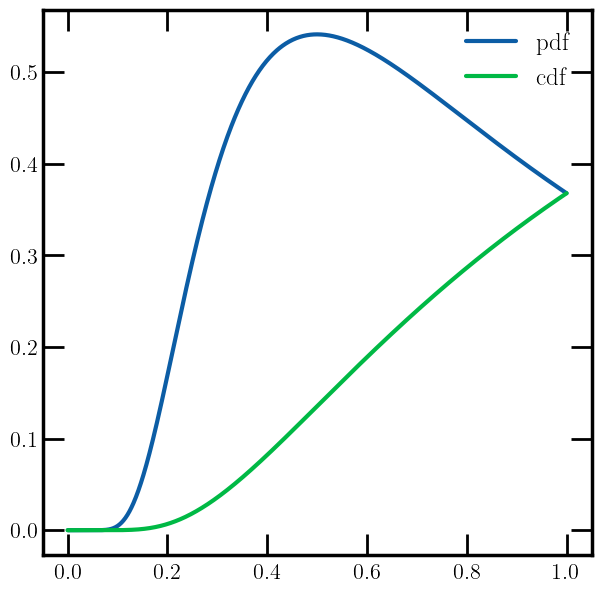

In [62]:
def f(t):
    return jnp.exp(t)

def construct_pdf(function):

    derivative = jnp.vectorize(jax.grad(function))

    def pdf(x):
        t = jnp.log(x)
        return derivative(-t) * jnp.exp(-function(-t)) / x

    return pdf

def construct_cdf(function):

    def cdf(x):
        return jnp.exp(-function(-jnp.log(x)))

    return cdf

pdf = construct_pdf(f)
cdf = construct_cdf(f)

x = np.linspace(0.0, 1, 1000)
y = pdf(x)
z = cdf(x)

fig, ax = newplot("full")
ax.plot(x, y, label='pdf')
ax.plot(x, z, label='cdf')
# ax.set_yscale('log')
ax.legend()


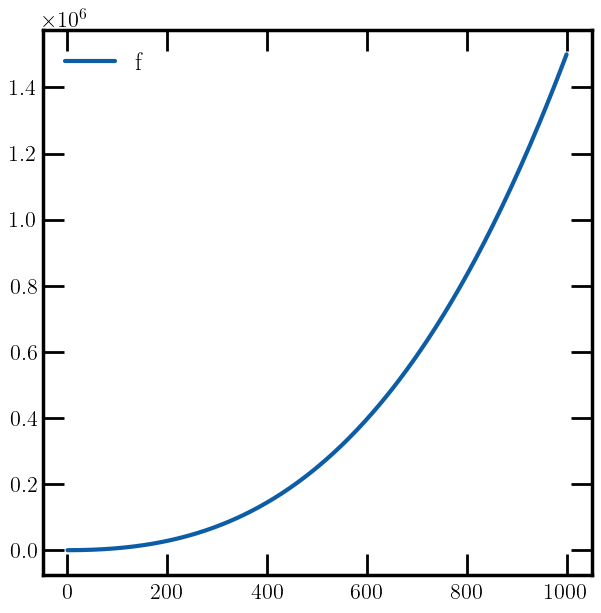

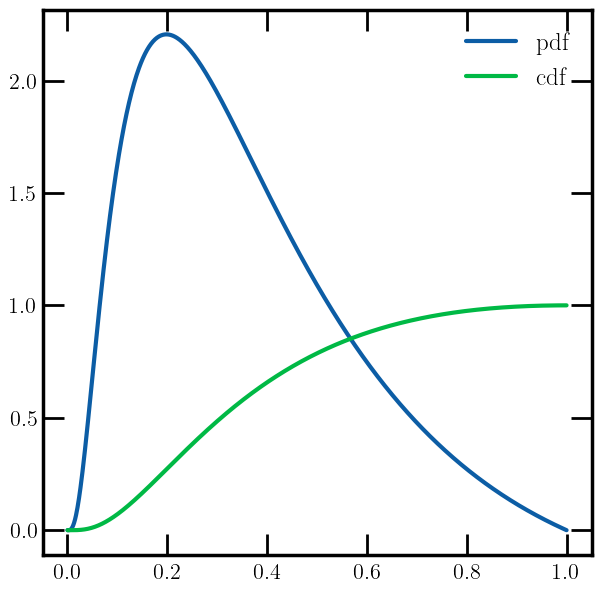

In [61]:
c_0 = 0.0
c_1 = 0.0
c_2 = 1.0 / 2.0
c_3 = 0.001


def f(t):
    return c_0 + c_1 * t + c_2 * t**2 + c_3 * t**3


def construct_pdf(function):

    derivative = jnp.vectorize(jax.grad(function))

    def pdf(x):
        t = jnp.log(x)
        return derivative(-t) * jnp.exp(-function(-t)) / x

    return pdf

def construct_cdf(function):

    def cdf(x):
        return jnp.exp(-function(-jnp.log(x)))

    return cdf


fig, ax = newplot("full")
t = np.logspace(0.0, 3, 1000)
y = f(t)
ax.plot(t, y, label='f')
ax.legend()



# ###################################

pdf = construct_pdf(f)
cdf = construct_cdf(f)

x = np.linspace(0.0, 1, 1000)
y = pdf(x)
z = cdf(x)

fig, ax = newplot("full")
ax.plot(x, y, label='pdf')
ax.plot(x, z, label='cdf')
# ax.set_yscale('log')
ax.legend()


# Inverse CDF

Given the CDF $P(X \leq x) = \exp[-f\left(\log(\frac{1}{x})\right)]$, we can find the inverse CDF by solving for $x$:

$x = \exp[-f^{-1}(-\log(P))]$.

So we just need to find $f^{-1}$.

Given that $f(t) = \int_0^t ds f'(s)$, we can solve for $t$:

